# Notebook ARN_Lab03

@Authors: Parisod Nathan & Lestiboudois Maxime

## Data processing and organization

In [7]:
# Disable warnings for cleaner outputimport warnings
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight

# TensorFlow / Keras
import tensorflow as tf
from keras import layers
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adamax

In [8]:
# Load EEG training and test data
train_1 = pd.read_csv('EEG_mouse_data_1.csv')
train_2 = pd.read_csv('EEG_mouse_data_2.csv')
test = pd.read_csv('EEG_mouse_data_test.csv')

# Concatenate training data
train = pd.concat([train_1, train_2], ignore_index=True)

In [9]:
# Feature and target column selection
features = train.columns[1:26]
X_train = train[features]
X_test = test[features]

y_train = train['state']

In [10]:
# Normalization and conversion of normalized data into a DataFrame
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=features)

In [11]:
# Quick check
print(X_train_scaled.head())
print(X_test_scaled.head())

   amplitude_around_1_Hertz  amplitude_around_2_Hertz  \
0                 -0.209955                 -0.081998   
1                 -0.183434                 -0.325791   
2                 -0.143389                  3.683546   
3                 -0.443261                  0.947062   
4                 -0.187587                 -0.238456   

   amplitude_around_3_Hertz  amplitude_around_4_Hertz  \
0                 -0.105121                 -0.027861   
1                 -0.230518                  0.068381   
2                  1.390184                  0.315788   
3                  2.070365                  0.140069   
4                 -0.177577                  0.177870   

   amplitude_around_5_Hertz  amplitude_around_6_Hertz  \
0                  0.818127                 -0.239219   
1                  0.740384                  0.553920   
2                  0.036759                 -0.564602   
3                 -0.510886                 -0.573552   
4                  0.570556  

In [12]:
# Configuration of 3-fold cross-validation with shuffling
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Display of indices for validation
for train_index, val_index in kf.split(X_train_scaled):
    print("Training indices:", train_index)
    print("Validation indices:", val_index)

Training indices: [    0     2     3 ... 40859 40860 40862]
Validation indices: [    1     4     6 ... 40856 40857 40861]
Training indices: [    1     2     4 ... 40859 40860 40861]
Validation indices: [    0     3     5 ... 40851 40858 40862]
Training indices: [    0     1     3 ... 40858 40861 40862]
Validation indices: [    2     9    10 ... 40854 40859 40860]


## First experiment

In [13]:
# Prepare and encode the labels
y_binary = y_train.replace({'n': 'asleep', 'r': 'asleep', 'w': 'awake'})

le = LabelEncoder()
y_encoded = le.fit_transform(y_binary)

In [14]:
model = Sequential([
    InputLayer(input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer=Adamax(), loss='binary_crossentropy', metrics=['accuracy'])

# Train with EarlyStopping
es = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7405 - loss: 0.5323 - val_accuracy: 0.8564 - val_loss: 0.3512
Epoch 2/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8564 - loss: 0.3536 - val_accuracy: 0.8687 - val_loss: 0.3310
Epoch 3/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8669 - loss: 0.3400 - val_accuracy: 0.8691 - val_loss: 0.3259
Epoch 4/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8730 - loss: 0.3246 - val_accuracy: 0.8697 - val_loss: 0.3260
Epoch 5/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8782 - loss: 0.3172 - val_accuracy: 0.8707 - val_loss: 0.3247
Epoch 6/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8779 - loss: 0.3106 - val_accuracy: 0.8707 - val_loss: 0.3220
Epoch 7/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8789 - loss: 0.3115 - val_accuracy: 0.8721 - val_loss: 0.3189
Epoch 8/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8820 - loss: 0.3018 - 

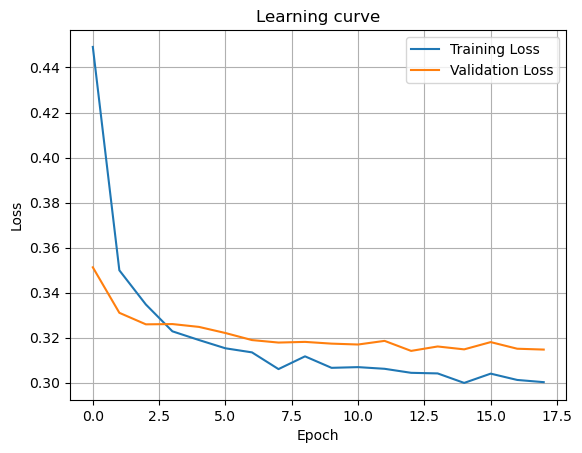

In [15]:
# Visualization of the learning curve (loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend()
plt.grid()
plt.show()

1277/1277 ━━━━━━━━━━━━━━━━━━━━ 1s 478us/step


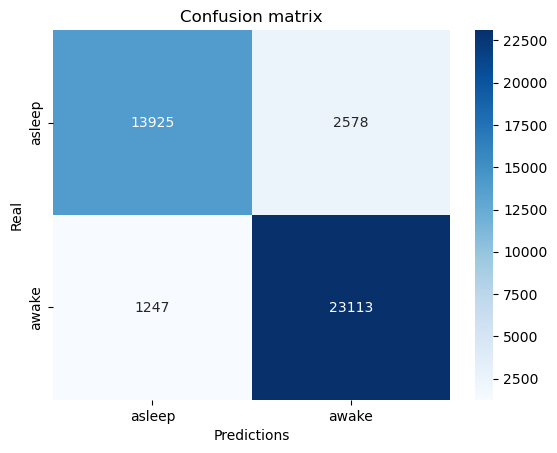

              precision    recall  f1-score   support

      asleep       0.92      0.84      0.88     16503
       awake       0.90      0.95      0.92     24360

    accuracy                           0.91     40863
   macro avg       0.91      0.90      0.90     40863
weighted avg       0.91      0.91      0.91     40863



In [10]:
# Visualization of the confusion matrix and Classification report
# Predictions on the training data
y_pred = (model.predict(X_train_scaled) > 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_encoded, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.title('Confusion matrix')
plt.show()

# Classification report (F1-score, precision, recall)
print(classification_report(y_encoded, y_pred, target_names=le.classes_))

## Second experiment

In [23]:
# Re-encode labels (n / r / w)
le = LabelEncoder()
y_encoded = le.fit_transform(y_train)
y_onehot = to_categorical(y_encoded)

# Compute class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(weights))

In [24]:
# Creation and training of the MLP model
model = Sequential([
    InputLayer(input_shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3-class classification
])

model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train with validation split and early stopping
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_scaled, y_onehot,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weight_dict,
    callbacks=[es],
    verbose=1
)

Epoch 1/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6029 - loss: 1.0077 - val_accuracy: 0.8034 - val_loss: 0.5432
Epoch 2/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7417 - loss: 0.6832 - val_accuracy: 0.8094 - val_loss: 0.5269
Epoch 3/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7720 - loss: 0.6231 - val_accuracy: 0.8062 - val_loss: 0.5224
Epoch 4/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7856 - loss: 0.5682 - val_accuracy: 0.8002 - val_loss: 0.5277
Epoch 5/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7867 - loss: 0.5700 - val_accuracy: 0.8014 - val_loss: 0.5180
Epoch 6/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7887 - loss: 0.5643 - val_accuracy: 0.8074 - val_loss: 0.5080
Epoch 7/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7986 - loss: 0.5422 - val_accuracy: 0.8085 - val_loss: 0.5003
Epoch 8/50
1022/1022 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8022 - loss: 0.5360 - 

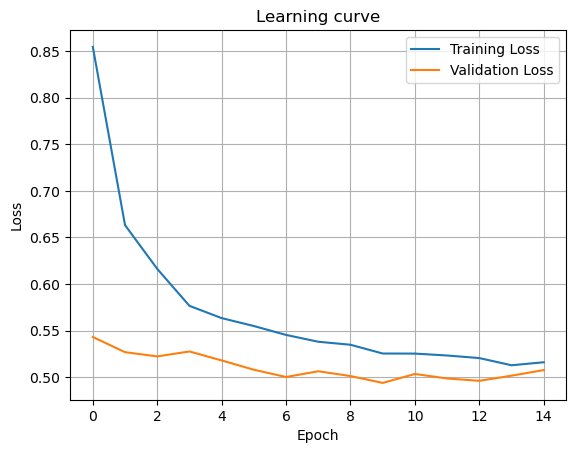

In [25]:
# Visualization of the learning curve (loss)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning curve')
plt.legend()
plt.grid()
plt.show()

In [26]:
# Predictions and evaluation
# Predictions (returns probabilities → take the class with the highest probability)
y_pred_probs = model.predict(X_train_scaled, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_onehot, axis=1)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

           n       0.89      0.88      0.88     13664
           r       0.38      0.73      0.50      2839
           w       0.92      0.83      0.87     24360

    accuracy                           0.84     40863
   macro avg       0.73      0.81      0.75     40863
weighted avg       0.87      0.84      0.85     40863



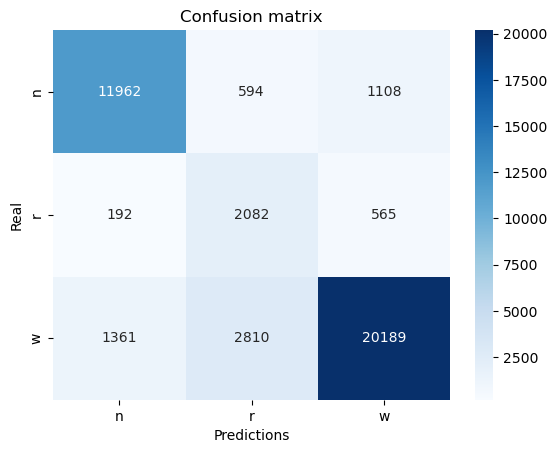

In [27]:
# Generate and display the confusion matrix
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predictions')
plt.ylabel('Real')
plt.title('Confusion matrix')
plt.show()

## Competition

In [16]:
# Combine the two training datasets (vertical concatenation without shuffling)
data = pd.concat([train_1, train_2], ignore_index=True)
print("Training data size:", data.shape)
print("Test data size:", test.shape)
print(data.head(5))  # Display the size of the training and test sets, and preview the first 5 rows

Training data size: (40863, 102)
Test data size: (80109, 101)
  state  amplitude_around_1_Hertz  amplitude_around_2_Hertz  \
0     n                  0.000009                  0.000014   
1     n                  0.000010                  0.000010   
2     n                  0.000011                  0.000077   
3     w                  0.000003                  0.000031   
4     w                  0.000010                  0.000011   

   amplitude_around_3_Hertz  amplitude_around_4_Hertz  \
0                  0.000013                  0.000014   
1                  0.000011                  0.000015   
2                  0.000034                  0.000019   
3                  0.000044                  0.000016   
4                  0.000012                  0.000017   

   amplitude_around_5_Hertz  amplitude_around_6_Hertz  \
0                  0.000023                  0.000009   
1                  0.000022                  0.000017   
2                  0.000013                  

In [17]:
# Select 25 amplitude-based features
feature_cols = [col for col in data.columns if col.startswith('amplitude_')][:25]

# Extract features and labels from the combined training dataset
X = data[feature_cols].values
y_labels = data['state'].values

# Encode labels numerically and apply one-hot encoding
unique_classes = np.unique(y_labels)            # ex: array(['n','r','w'], dtype=object)
class_to_idx = {cls: idx for idx, cls in enumerate(unique_classes)}
y_num = np.array([class_to_idx[cls] for cls in y_labels])

# One-hot encoding of labels
num_classes = len(unique_classes)  # Should be 3
y_onehot = np.eye(num_classes)[y_num]

# Normalize the features using StandardScaler (fitted on training set)
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Compute class weights to handle class imbalance during training
class_counts = {cls: (y_labels == cls).sum() for cls in unique_classes}
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_num), y=y_num)
class_weight_dict = {i: w for i, w in enumerate(weights)}
print("Class distribution:", class_counts)
print("Class weights used:", {unique_classes[i]: round(w, 3) for i, w in class_weight_dict.items()})

Class distribution: {'n': 13664, 'r': 2839, 'w': 24360}
Class weights used: {'n': 0.997, 'r': 4.798, 'w': 0.559}


In [18]:
# Define a basic MLP architecture with dropout and batch normalization
def create_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adamax(), loss='categorical_crossentropy', metrics=['accuracy'])   # Compile the model with Adamax optimizer and categorical crossentropy loss
    return model

# Perform 10-fold time series cross-validation (without shuffling)
tscv = TimeSeriesSplit(n_splits=10)
fold = 1
all_y_true, all_y_pred = [], []

for train_idx, val_idx in tscv.split(X_scaled):
    X_train_cv, X_val_cv = X_scaled[train_idx], X_scaled[val_idx]
    y_train_cv, y_val_cv = y_onehot[train_idx], y_num[val_idx]   # One-hot for training, integer labels for evaluation

    model_cv = create_mlp(X_train_cv.shape[1])
    es = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
    model_cv.fit(X_train_cv, y_train_cv, epochs=30, batch_size=32, verbose=0, 
                 validation_data=(X_val_cv, np.eye(num_classes)[y_val_cv]), 
                 callbacks=[es], class_weight=class_weight_dict)
    # Predictions on the validation part of the fold
    y_pred_cv = model_cv.predict(X_val_cv, verbose=0).argmax(axis=1)
    all_y_true.extend(y_val_cv.tolist())
    all_y_pred.extend(y_pred_cv.tolist())
    print(f"Fold {fold} - Exactitude validation : {100 * (y_pred_cv==y_val_cv).mean():.1f}%")
    fold += 1

# Global classification report across all folds
print("\nAverage validation performance (10-fold):")
print(classification_report(all_y_true, all_y_pred, target_names=list(unique_classes)))

Fold 1 - Exactitude validation : 59.0%
Fold 2 - Exactitude validation : 81.7%
Fold 3 - Exactitude validation : 83.0%
Fold 4 - Exactitude validation : 85.1%
Fold 5 - Exactitude validation : 75.0%
Fold 6 - Exactitude validation : 73.0%
Fold 7 - Exactitude validation : 84.4%
Fold 8 - Exactitude validation : 80.4%
Fold 9 - Exactitude validation : 81.6%
Fold 10 - Exactitude validation : 82.6%

Average validation performance (10-fold):
              precision    recall  f1-score   support

           n       0.88      0.76      0.82     13656
           r       0.36      0.62      0.45      2839
           w       0.83      0.82      0.83     20645

    accuracy                           0.79     37140
   macro avg       0.69      0.73      0.70     37140
weighted avg       0.81      0.79      0.80     37140



Model 1 trained (26 epochs completed).


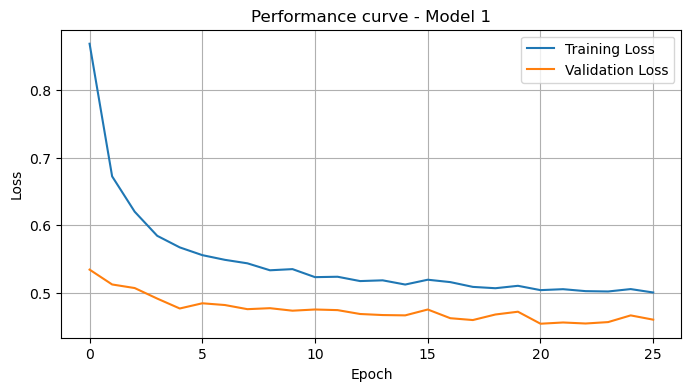

Confusion matrix - Model 1:


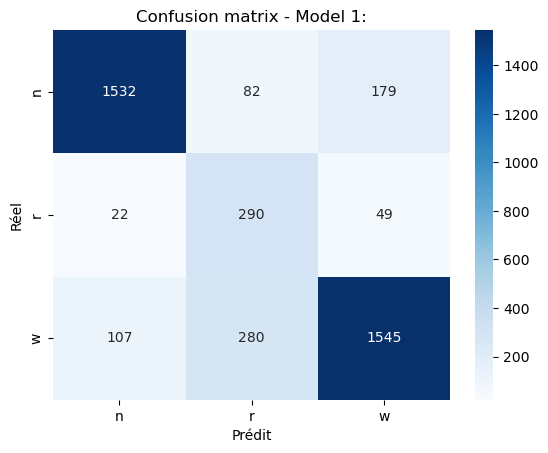

Classification report - Model 1:
              precision    recall  f1-score   support

           n       0.92      0.85      0.89      1793
           r       0.44      0.80      0.57       361
           w       0.87      0.80      0.83      1932

    accuracy                           0.82      4086
   macro avg       0.75      0.82      0.76      4086
weighted avg       0.86      0.82      0.83      4086

Model 2 trained (34 epochs completed).


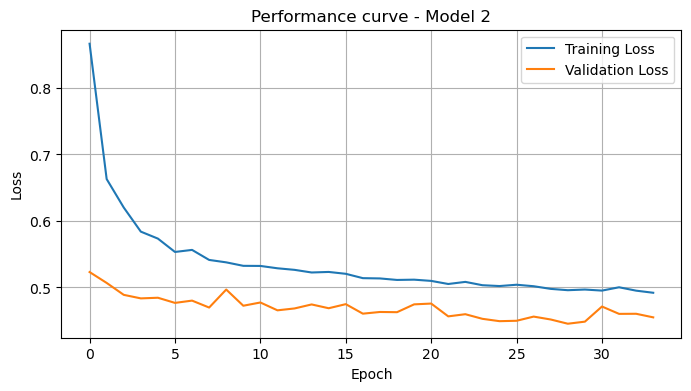

Confusion matrix - Model 2:


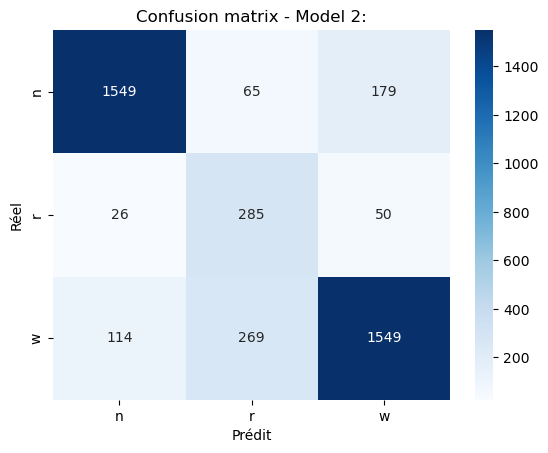

Classification report - Model 2:
              precision    recall  f1-score   support

           n       0.92      0.86      0.89      1793
           r       0.46      0.79      0.58       361
           w       0.87      0.80      0.84      1932

    accuracy                           0.83      4086
   macro avg       0.75      0.82      0.77      4086
weighted avg       0.86      0.83      0.84      4086

Model 3 trained (26 epochs completed).


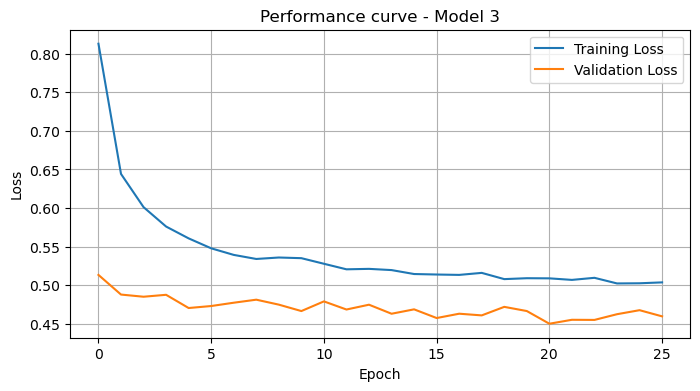

Confusion matrix - Model 3:


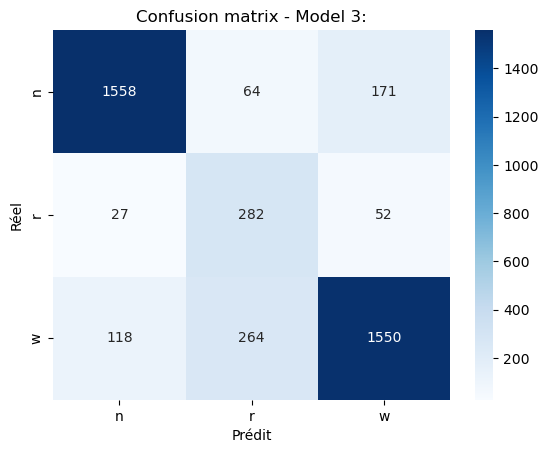

Classification report - Model 3:
              precision    recall  f1-score   support

           n       0.91      0.87      0.89      1793
           r       0.46      0.78      0.58       361
           w       0.87      0.80      0.84      1932

    accuracy                           0.83      4086
   macro avg       0.75      0.82      0.77      4086
weighted avg       0.86      0.83      0.84      4086

Model 4 trained (11 epochs completed).


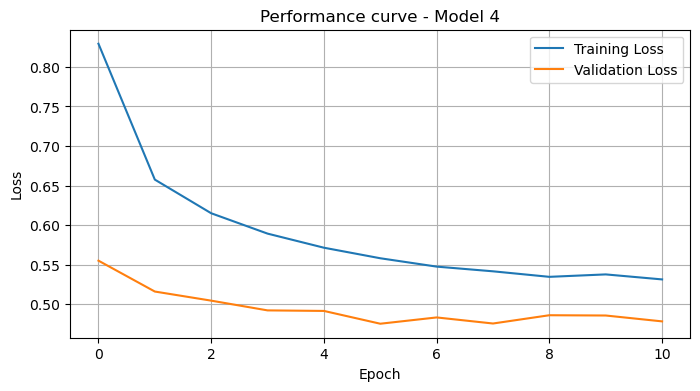

Confusion matrix - Model 4:


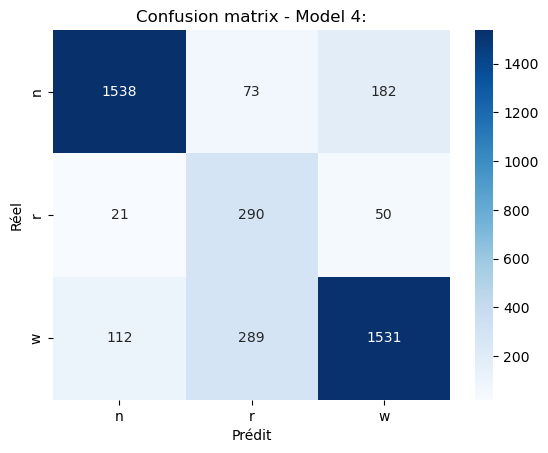

Classification report - Model 4:
              precision    recall  f1-score   support

           n       0.92      0.86      0.89      1793
           r       0.44      0.80      0.57       361
           w       0.87      0.79      0.83      1932

    accuracy                           0.82      4086
   macro avg       0.74      0.82      0.76      4086
weighted avg       0.85      0.82      0.83      4086

Model 5 trained (27 epochs completed).


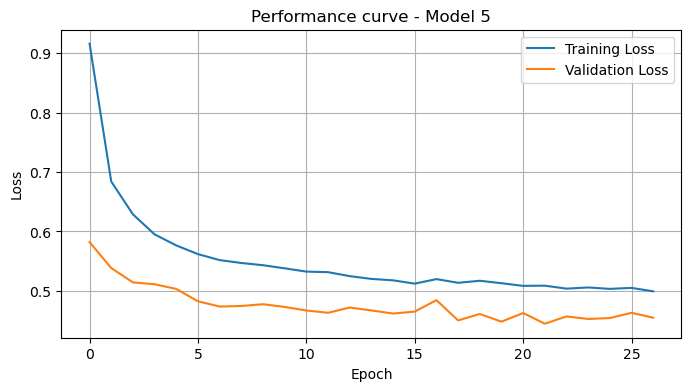

Confusion matrix - Model 5:


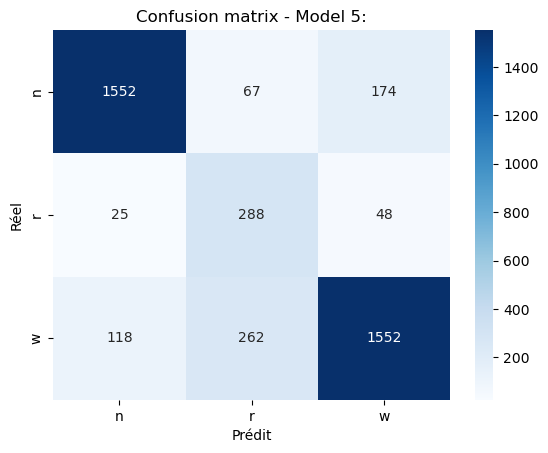

Classification report - Model 5:
              precision    recall  f1-score   support

           n       0.92      0.87      0.89      1793
           r       0.47      0.80      0.59       361
           w       0.87      0.80      0.84      1932

    accuracy                           0.83      4086
   macro avg       0.75      0.82      0.77      4086
weighted avg       0.86      0.83      0.84      4086



In [19]:
# 90%/10% split for internal training/validation (last 10% of time as validation)

N = X_scaled.shape[0]
val_size = int(0.1 * N)
X_train_full, X_val_full = X_scaled[:N-val_size], X_scaled[N-val_size:]
y_train_full, y_val_full = y_onehot[:N-val_size], y_num[N-val_size:]

models = []
histories = []

for i in range(5):
    model = create_mlp(X_train_full.shape[1])
    es = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)
    history = model.fit(X_train_full, y_train_full, epochs=50, batch_size=32, verbose=0, 
                        validation_data=(X_val_full, np.eye(num_classes)[y_val_full]), 
                        callbacks=[es], class_weight=class_weight_dict)
    models.append(model)
    histories.append(history.history)
    print(f"Model {i+1} trained ({len(history.history['loss'])} epochs completed).")

    # Display of the performance curve
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Performance curve - Model {i+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predictions on validation set and confusion matrix
    y_pred_val = model.predict(X_val_full, verbose=0).argmax(axis=1)
    cm = confusion_matrix(y_val_full, y_pred_val)
    print(f"Confusion matrix - Model {i+1}:")
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
    plt.xlabel('Prédit')
    plt.ylabel('Réel')
    plt.title(f"Confusion matrix - Model {i+1}:")
    plt.show()

    print(f"Classification report - Model {i+1}:")
    print(classification_report(y_val_full, y_pred_val, target_names=unique_classes))

In [21]:
# Average of predicted probabilities from each model (ensemble)
test_probs = np.zeros((test.shape[0], num_classes))
for model in models:
    test_probs += model.predict(scaler.transform(test[feature_cols]), verbose=0)
test_probs /= len(models)

# Conversion to predicted labels ('n', 'r', 'w')
test_pred_indices = test_probs.argmax(axis=1)
idx_to_class = {v: k for k, v in class_to_idx.items()}
test_pred_labels = np.array([idx_to_class[idx] for idx in test_pred_indices])

# Saving predictions
np.save('test_pred.npy', test_pred_labels)
print("Predictions saved in test_pred.npy")
print("Example predictions:", test_pred_labels[2000:2010])
print("Total number of predictions:", test_pred_labels.shape)

Predictions saved in test_pred.npy
Example predictions: ['w' 'w' 'w' 'n' 'w' 'r' 'w' 'w' 'r' 'r']
Total number of predictions: (80109,)
